[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cselab/plasma/blob/main/run.ipynb)


In [ ]:
%pip install -qq fusion_surrogates

In [ ]:
%%sh
mkdir -p geo
wget -q https://raw.githubusercontent.com/google-deepmind/torax/refs/heads/main/torax/data/third_party/geo/ITER_hybrid_citrin_equil_cheasedata.mat2cols \
  -O geo/ITER_hybrid_citrin_equil_cheasedata.mat2cols

In [2]:
from fusion_surrogates.qlknn import qlknn_model
from jax import numpy as jnp
import jax
import numpy as np
import os
import scipy

In [3]:
class g:
    pass


class l:
    pass


jax.config.update("jax_enable_x64", True)
g.keV_to_J = 1e3 * 1.602176634e-19
g.keV_m3_to_Pa = 1.6e-16
g.m_amu = 1.6605390666e-27
g.q_e = 1.602176634e-19
g.m_e = 9.1093837e-31
g.epsilon_0 = 8.85418782e-12
g.mu_0 = 4 * np.pi * 1e-7
g.eps = 1e-7
g.EPS_CONVECTION = 1e-20
g.EPS_PECLET = 1e-3
g.savgol_w = 5
g.T_E_ALLOWED_RANGE = (0.1, 100.0)
g.scaling_n_e = 1e20
g.sym = "D", "T", "Ne"
g.z = dict(zip(g.sym, [1.0, 1.0, 10.0]))
g.A = dict(zip(g.sym, [2.0141, 3.0160, 20.180]))


def grad_op(bc):
    D = np.zeros((g.n + 1, g.n))
    b = np.zeros(g.n + 1)
    for i in range(1, g.n):
        D[i, i - 1] = -g.inv_dx
        D[i, i] = g.inv_dx
    b[0] = bc[2] if bc[2] is not None else 0.0
    if bc[1] is not None:
        D[g.n, g.n - 1] = -2.0 * g.inv_dx
        b[g.n] = 2.0 * g.inv_dx * bc[1]
    else:
        b[g.n] = bc[3] if bc[3] is not None else 0.0
    return D, b


def grad_op_nu(inv_dx_array, bc):
    D = np.zeros((g.n + 1, g.n))
    b = np.zeros(g.n + 1)
    for i in range(1, g.n):
        D[i, i - 1] = -inv_dx_array[i - 1]
        D[i, i] = inv_dx_array[i - 1]
    b[0] = bc[2] if bc[2] is not None else 0.0
    if bc[1] is not None:
        D[g.n, g.n - 1] = -2.0 * inv_dx_array[-1]
        b[g.n] = 2.0 * inv_dx_array[-1] * bc[1]
    return D, b


def face_op(bc_right_face, bc_right_grad):
    I = np.zeros((g.n + 1, g.n))
    I[0, 0] = 1.0
    for i in range(1, g.n):
        I[i, i - 1] = 0.5
        I[i, i] = 0.5
    b = np.zeros(g.n + 1)
    if bc_right_face is not None:
        b[g.n] = bc_right_face
    else:
        I[g.n, g.n - 1] = 1.0
        b[g.n] = 0.5 * g.dx * (bc_right_grad
                               if bc_right_grad is not None else 0.0)
    return I, b


def conv_terms(v_face, d_face, bc):
    eps = g.EPS_CONVECTION
    is_neg = d_face < 0.0
    nonzero_sign = jnp.ones_like(is_neg) - 2 * is_neg
    d_face = nonzero_sign * jnp.maximum(eps, jnp.abs(d_face))
    half = jnp.array([0.5], dtype=jnp.float64)
    ones = jnp.ones_like(v_face[1:-1])
    scale = jnp.r_[half, ones, half]
    ratio = scale * g.dx * v_face / d_face
    left_peclet = -ratio[:-1]
    right_peclet = ratio[1:]

    def peclet_to_alpha(p):
        eps = g.EPS_PECLET
        p = jnp.where(jnp.abs(p) < eps, eps, p)
        alpha_pg10 = (p - 1) / p
        alpha_p0to10 = ((p - 1) + (1 - p / 10)**5) / p
        alpha_pneg10to0 = ((1 + p / 10)**5 - 1) / p
        alpha_plneg10 = -1 / p
        alpha = 0.5 * jnp.ones_like(p)
        alpha = jnp.where(p > 10.0, alpha_pg10, alpha)
        alpha = jnp.where(jnp.logical_and(10.0 >= p, p > eps), alpha_p0to10,
                          alpha)
        alpha = jnp.where(jnp.logical_and(-eps > p, p >= -10), alpha_pneg10to0,
                          alpha)
        alpha = jnp.where(p < -10.0, alpha_plneg10, alpha)
        return alpha

    la = peclet_to_alpha(left_peclet)
    ra = peclet_to_alpha(right_peclet)
    lv = v_face[:-1]
    rv = v_face[1:]
    diag = (la * lv - ra * rv) * g.inv_dx
    above = -(1 - ra[:-1]) * rv[:-1] * g.inv_dx
    below = (1 - la[1:]) * lv[1:] * g.inv_dx
    mat = jnp.diag(diag) + jnp.diag(above, 1) + jnp.diag(below, -1)
    vec = jnp.zeros_like(diag)
    mat = mat.at[0, 0].set((v_face[0] - ra[0] * v_face[1]) * g.inv_dx)
    vec = vec.at[0].set(-v_face[0] * (1 - la[0]) * bc[2])
    if bc[1] is not None:
        mat = mat.at[-1, -1].set(
            (v_face[-2] * la[-1] + v_face[-1] * (1 - 2 * ra[-1])) * g.inv_dx)
        vec = vec.at[-1].set(-2 * v_face[-1] * (1 - ra[-1]) * bc[1] * g.inv_dx)
    else:
        mat = mat.at[-1,
                     -1].set(-(v_face[-1] - v_face[-2] * la[-1]) * g.inv_dx)
        vec = vec.at[-1].set(-v_face[-1] * (1 - ra[-1]) * bc[3])
    return mat, vec


def diff_terms(d, bc):
    diag = jnp.asarray(-d[1:] - d[:-1]).at[0].set(-d[1])
    off = d[1:-1]
    vec = jnp.zeros(g.n).at[0].set(-d[0] * bc[2] * g.inv_dx)
    if bc[1] is not None:
        diag = diag.at[-1].set(-2 * d[-1] - d[-2])
        vec = vec.at[-1].set(2 * d[-1] * bc[1] * g.inv_dx_sq)
    else:
        diag = diag.at[-1].set(-d[-2])
        vec = vec.at[-1].set(d[-1] * bc[3] * g.inv_dx)
    return (jnp.diag(diag) + jnp.diag(off, 1) +
            jnp.diag(off, -1)) * g.inv_dx_sq, vec


def trans_terms(v, d, bc):
    diff_mat, diff_vec = diff_terms(d, bc)
    conv_mat, conv_vec = conv_terms(v, d, bc)
    return diff_mat + conv_mat, diff_vec + conv_vec


def log_lambda_ei(n_e, T_e_keV):
    return 31.3 - 0.5 * jnp.log(n_e) + jnp.log(T_e_keV * 1e3)


def _calculate_log_tau_e_Z1(T_e, n_e, log_lambda_ei):
    return (jnp.log(12 * jnp.pi**1.5 / (n_e * log_lambda_ei)) -
            4 * jnp.log(g.q_e) + 0.5 * jnp.log(g.m_e / 2.0) +
            2 * jnp.log(g.epsilon_0) + 1.5 * jnp.log(T_e * g.keV_to_J))


g.MAVRIN_Z_COEFFS = {
    "Ne":
    np.array([
        [-2.5303e01, -6.4696e01, -5.3631e01, -1.3242e01, 8.9737e00],
        [-7.0678e00, 3.6868e00, -8.0723e-01, 2.1413e-01, 9.9532e00],
        [0.0000e00, 0.0000e00, 0.0000e00, 0.0000e00, 1.0000e01],
    ]),
}
g.T_intervals = {
    "Ne": np.array([0.5, 2.0]),
}


def z_avg_species(T_e, ion_symbol):
    if ion_symbol not in g.MAVRIN_Z_COEFFS:
        return jnp.ones_like(T_e) * g.z[ion_symbol]
    T_e = jnp.clip(T_e, *g.T_E_ALLOWED_RANGE)
    interval_indices = jnp.searchsorted(g.T_intervals[ion_symbol], T_e)
    Zavg_coeffs_in_range = jnp.take(g.MAVRIN_Z_COEFFS[ion_symbol],
                                    interval_indices,
                                    axis=0).transpose()
    X = jnp.log10(T_e)
    Zavg = jnp.polyval(Zavg_coeffs_in_range, X)
    return Zavg


def z_avg(ion_symbols, T_e, fractions):
    Z_per_species = jnp.stack(
        [z_avg_species(T_e, ion_symbol) for ion_symbol in ion_symbols])
    fractions = fractions if fractions.ndim == 2 else fractions[:, jnp.newaxis]
    Z_avg = jnp.sum(fractions * Z_per_species, axis=0)
    Z2_avg = jnp.sum(fractions * Z_per_species**2, axis=0)
    return Z_avg, Z2_avg, Z_per_species


def nu_e_star(q, n_e, T_e, Z_eff, log_lambda_ei):
    return (6.921e-18 * q * g.R_major * n_e * Z_eff * log_lambda_ei /
            (((T_e * 1e3)**2) * (g.geo_epsilon_face + g.eps)**1.5))


def nu_i_star(q, n_i, T_i, Z_eff, log_lambda_ii):
    return (4.9e-18 * q * g.R_major * n_i * Z_eff**4 * log_lambda_ii /
            (((T_i * 1e3)**2) * (g.geo_epsilon_face + g.eps)**1.5))


def gaussian_profile(center, width, total):
    r = g.cell_centers
    S = jnp.exp(-((r - center)**2) / (2 * width**2))
    C = total / jnp.sum(S * g.geo_vpr * g.dx)
    return C * S


g.EPSILON_NN = 1 / 3
g.rho_smooth_lim = 0.1


def heat_source():
    profile = gaussian_profile(g.heat_loc, g.heat_w, g.heat_P)
    source_i = profile * (1 - g.heat_efrac)
    source_e = profile * g.heat_efrac
    return source_i, source_e


def particle_source():
    source_n = gaussian_profile(g.part_loc, g.part_w, g.part_S)
    source_n += gaussian_profile(g.pellet_loc, g.pellet_w, g.pellet_S)
    r = g.cell_centers
    S = jnp.exp(-(1.0 - r) / g.puff_decay)
    C = g.puff_S / jnp.sum(S * g.geo_vpr * g.dx)
    source_n += C * S
    return source_n


def current_source():
    I_curr = g.Ip * g.curr_frac
    curr_form = jnp.exp(-((g.cell_centers - g.curr_loc)**2) /
                        (2 * g.curr_w**2))
    C = I_curr / jnp.sum(curr_form * g.geo_spr * g.dx)
    source_p_ext = C * curr_form
    return source_p_ext


def fusion_source(e, i_f, ni_f):
    prod = 1.0
    for frac, sym in zip(g.ion_fractions, g.ion_names):
        if sym in ("D", "T"):
            prod *= frac
    theta = i_f / (1 - (i_f * (g.fusion_C2 + i_f *
                               (g.fusion_C4 + i_f * g.fusion_C6))) /
                   (1 + i_f * (g.fusion_C3 + i_f *
                               (g.fusion_C5 + i_f * g.fusion_C7))))
    xi = (g.fusion_BG**2 / (4 * theta))**(1 / 3)
    logsv = jnp.log(g.fusion_C1 * theta) + 0.5 * jnp.log(
        xi / (g.fusion_mrc2 * i_f**3)) - 3 * xi - jnp.log(1e6)
    Pf = jnp.exp(jnp.log(prod * g.fusion_Efus) + 2 * jnp.log(ni_f) + logsv)
    Pc = 0.5 * (Pf[:-1] + Pf[1:])
    x2 = g.fusion_birth_energy / (g.fusion_critical_energy_coeff * e)
    x = jnp.sqrt(x2)
    fi = 2 * ((1 / 6) * jnp.log((1 - x + x2) / (1 + 2 * x + x2)) + (jnp.arctan(
        (2 * x - 1) / jnp.sqrt(3)) + jnp.pi / 6) / jnp.sqrt(3)) / x2
    return Pc * fi * g.fusion_alpha_fraction, Pc * (
        1 - fi) * g.fusion_alpha_fraction


def qei_coupling(e, n, ni, nz, Zi, Zz, Ai, Az):
    log_tau = _calculate_log_tau_e_Z1(e, n, log_lambda_ei(n, e))
    Zw = (ni * Zi**2 / Ai + nz * Zz**2 / Az) / n
    Q = jnp.exp(
        jnp.log(g.Qei_multiplier * 1.5 * n) + jnp.log(g.keV_to_J / g.m_amu) +
        jnp.log(2 * g.m_e) + jnp.log(Zw) - log_tau) * g.geo_vpr
    return -Q, -Q, Q, Q


def bootstrap_current(i_f, e_f, n_f, ni_f, p_g, q, i_g, e_g, n_g, ni_g, Zi_f,
                      Zeff_f):
    ft = g.f_trap
    log_lei = log_lambda_ei(n_f, e_f)
    log_lii = 30 - 0.5 * jnp.log(ni_f) + 1.5 * jnp.log(
        i_f * 1e3) - 3 * jnp.log(Zi_f)
    nue = nu_e_star(q, n_f, e_f, Zeff_f, log_lei)
    nui = nu_i_star(q, ni_f, i_f, Zeff_f, log_lii)
    ft31 = ft / (1 + (1 - 0.1 * ft) * jnp.sqrt(nue) + 0.5 *
                 (1 - ft) * nue / Zeff_f)
    L31 = (1 + 1.4 /
           (Zeff_f + 1)) * ft31 - 1.9 / (Zeff_f + 1) * ft31**2 + 0.3 / (
               Zeff_f + 1) * ft31**3 + 0.2 / (Zeff_f + 1) * ft31**4
    ft32ee = ft / (1 + 0.26 * (1 - ft) * jnp.sqrt(nue) + 0.18 *
                   (1 - 0.37 * ft) * nue / jnp.sqrt(Zeff_f))
    ft32ei = ft / (1 + (1 + 0.6 * ft) * jnp.sqrt(nue) + 0.85 *
                   (1 - 0.37 * ft) * nue * (1 + Zeff_f))
    F32ee = (0.05 + 0.62 * Zeff_f) / (Zeff_f * (1 + 0.44 * Zeff_f)) * (ft32ee - ft32ee**4) + \
            1 / (1 + 0.22 * Zeff_f) * (ft32ee**2 - ft32ee**4 - 1.2 * (ft32ee**3 - ft32ee**4)) + \
            1.2 / (1 + 0.5 * Zeff_f) * ft32ee**4
    F32ei = -(0.56 + 1.93 * Zeff_f) / (Zeff_f * (1 + 0.44 * Zeff_f)) * (ft32ei - ft32ei**4) + \
            4.95 / (1 + 2.48 * Zeff_f) * (ft32ei**2 - ft32ei**4 - 0.55 * (ft32ei**3 - ft32ei**4)) - \
            1.2 / (1 + 0.5 * Zeff_f) * ft32ei**4
    ft34 = ft / (1 + (1 - 0.1 * ft) * jnp.sqrt(nue) + 0.5 *
                 (1 - 0.5 * ft) * nue / Zeff_f)
    L34 = (1 + 1.4 /
           (Zeff_f + 1)) * ft34 - 1.9 / (Zeff_f + 1) * ft34**2 + 0.3 / (
               Zeff_f + 1) * ft34**3 + 0.2 / (Zeff_f + 1) * ft34**4
    a0 = -1.17 * (1 - ft) / (1 - 0.22 * ft - 0.19 * ft**2)
    alph = ((a0 + 0.25 *
             (1 - ft**2) * jnp.sqrt(nui)) / (1 + 0.5 * jnp.sqrt(nui)) +
            0.315 * nui**2 * ft**6) / (1 + 0.15 * nui**2 * ft**6)
    pe = n_f * e_f * g.keV_m3_to_Pa
    pi = ni_f * i_f * g.keV_m3_to_Pa
    gc = jnp.r_[jnp.zeros(1), -g.geo_F_face[1:] * 2 * jnp.pi / (g.B_0 * p_g[1:])]
    jbs = gc * (L31 * (pe * n_g / n_f + pi * ni_g / ni_f) +
                (L31 + F32ee + F32ei) * pe * e_g / e_f +
                (L31 + alph * L34) * pi * i_g / i_f)
    return 0.5 * (jbs[:-1] + jbs[1:])


def neoclassical_conductivity(e_f, n_f, q, Zeff_f):
    ft = g.f_trap
    NZ = 0.58 + 0.74 / (0.76 + Zeff_f)
    log_lei = log_lambda_ei(n_f, e_f)
    sig_sptz = 1.9012e04 * (e_f * 1e3)**1.5 / Zeff_f / NZ / log_lei
    nue = nu_e_star(q, n_f, e_f, Zeff_f, log_lei)
    ft33 = ft / (1 + (0.55 - 0.1 * ft) * jnp.sqrt(nue) + 0.45 *
                 (1 - ft) * nue / Zeff_f**1.5)
    sig_neo = 1 - ft33 * (1 + 0.36 / Zeff_f - ft33 *
                          (0.59 / Zeff_f - 0.23 / Zeff_f * ft33))
    sig_f = sig_sptz * sig_neo
    return 0.5 * (sig_f[:-1] + sig_f[1:])


def safe_lref(v, grad):
    r = jnp.where(jnp.abs(v) < g.eps, g.eps, -g.R_major * grad / v)
    return jnp.where(jnp.abs(r) < g.eps, g.eps, r)


def turbulent_transport(i_f, i_r, e_f, e_r, n_f, n_g, n_r, ni_f, ni_r, nz_f,
                        nz_r, p_g, q, ions_Z_eff_face):
    chiGB = ((g.ion_A_avg * g.m_amu)**0.5 / (g.B_0 * g.q_e)**2 *
             (i_f * g.keV_to_J)**1.5 / g.a_minor)
    lti = safe_lref(i_f, i_r)
    lte = safe_lref(e_f, e_r)
    lne = safe_lref(n_f, n_r)
    lni0 = safe_lref(ni_f, ni_r)
    lni1 = safe_lref(nz_f, nz_r)
    iota = jnp.abs(p_g[1:] / g.face_centers[1:])
    iota = jnp.r_[jnp.abs(p_g[1] * g.inv_dx)[None], iota]
    rm = g.geo_rmid_face
    smag = -rm * jnp.gradient(iota, rm) / iota
    eps_lcfs = rm[-1] / g.R_major
    x = jnp.where(jnp.abs(rm / rm[-1]) < g.eps, g.eps, rm / rm[-1])
    TiTe = i_f / e_f
    log_tau = _calculate_log_tau_e_Z1(e_f, n_f, log_lambda_ei(n_f, e_f))
    nu = 1 / jnp.exp(log_tau) * ions_Z_eff_face * g.coll_mult
    eps = jnp.clip(g.geo_rho_face / g.R_major, g.eps)
    tb = (q * g.R_major /
          (eps**1.5 * jnp.sqrt(e_f * g.keV_to_J / g.m_e))).at[0].set(
              q[1] * g.R_major /
              (eps[1]**1.5 * jnp.sqrt(e_f[1] * g.keV_to_J / g.m_e)))
    nu_star = jnp.log10(nu * tb)
    f0 = 2 * g.keV_to_J / g.B_0**2 * g.mu_0 * q**2
    alph = f0 * (e_f * n_f * (lte + lne) + ni_f * i_f *
                 (lti + lni0) + nz_f * i_f * (lti + lni1))
    smag = smag - alph / 2
    smag = jnp.where(q < 1, 0.1, smag)
    q = jnp.where(q < 1, 1, q)
    smag = jnp.where(smag - alph < -0.2, alph - 0.2, smag)
    features = jnp.c_[lti, lte, lne, lni0, q, smag, x * eps_lcfs / g.EPSILON_NN,
                      TiTe, nu_star, ni_f / n_f]
    out = g.model.predict(features)
    qi_itg_squeezed = out["efiITG"].squeeze()
    qi = qi_itg_squeezed + out["efiTEM"].squeeze()
    qe = (out["efeITG"].squeeze() * g.ITG_flux_ratio_correction +
          out["efeTEM"].squeeze() +
          out["efeETG"].squeeze() * g.ETG_correction_factor)
    pfe = out["pfeITG"].squeeze() + out["pfeTEM"].squeeze()
    gradient_reference_length = g.R_major
    gyrobohm_flux_reference_length = g.a_minor
    pfe_SI = pfe * n_f * chiGB / gyrobohm_flux_reference_length
    chi_i = ((gradient_reference_length / gyrobohm_flux_reference_length) *
             qi / lti) * chiGB
    chi_e = ((gradient_reference_length / gyrobohm_flux_reference_length) *
             qe / lte) * chiGB
    Deff = -pfe_SI / (n_g * g.geo_g1_over_vpr2_face * g.geo_rho_b + g.eps)
    Veff = pfe_SI / (n_f * g.geo_g0_over_vpr_face * g.geo_rho_b)
    Deff_mask = (((pfe >= 0) & (lne >= 0)) |
                 ((pfe < 0) & (lne < 0))) & (abs(lne) >= g.An_min)
    Veff_mask = jnp.invert(Deff_mask)
    d_e = jnp.where(Veff_mask, 0.0, Deff)
    v_e = jnp.where(Deff_mask, 0.0, Veff)
    active_mask = ((g.face_centers > g.transport_rho_min)
                   & (g.face_centers <= g.transport_rho_max)
                   & (g.face_centers <= g.rho_norm_ped_top))
    active_mask = jnp.asarray(active_mask).at[0].set(g.transport_rho_min == 0)
    chi_i = jnp.where(active_mask, chi_i, 0.0)
    chi_e = jnp.where(active_mask, chi_e, 0.0)
    d_e = jnp.where(active_mask, d_e, 0.0)
    v_e = jnp.where(active_mask, v_e, 0.0)
    chi_i = jnp.clip(chi_i, g.chi_min, g.chi_max)
    chi_e = jnp.clip(chi_e, g.chi_min, g.chi_max)
    d_e = jnp.clip(d_e, g.D_e_min, g.D_e_max)
    v_e = jnp.clip(v_e, g.V_e_min, g.V_e_max)
    chi_i = jnp.where(g.face_centers < g.rho_inner + g.eps, g.chi_i_inner,
                      chi_i)
    chi_e = jnp.where(g.face_centers < g.rho_inner + g.eps, g.chi_e_inner,
                      chi_e)
    d_e = jnp.where(g.face_centers < g.rho_inner + g.eps, g.D_e_inner, d_e)
    v_e = jnp.where(g.face_centers < g.rho_inner + g.eps, g.V_e_inner, v_e)
    lower_cutoff = 0.01
    kernel = jnp.exp(-jnp.log(2) *
                     (g.face_centers[:, jnp.newaxis] - g.face_centers)**2 /
                     (g.smooth_w**2 + g.eps))
    mask_outer_edge = g.rho_norm_ped_top - g.eps
    mask_inner_edge = g.rho_inner + g.eps
    mask = jnp.where(
        jnp.logical_and(
            g.face_centers > mask_inner_edge,
            g.face_centers < mask_outer_edge,
        ),
        1.0,
        0.0,
    )
    diag_mask = jnp.diag(mask)
    kernel = jnp.dot(diag_mask, kernel)
    num_rows = len(mask)
    mask_mat = jnp.tile(mask, (num_rows, 1))
    kernel *= mask_mat
    zero_row_mask = jnp.all(kernel == 0, axis=1)
    kernel = jnp.where(zero_row_mask[:, jnp.newaxis], jnp.eye(kernel.shape[0]),
                       kernel)
    row_sums = jnp.sum(kernel, axis=1)
    kernel /= row_sums[:, jnp.newaxis]
    kernel = jnp.where(kernel < lower_cutoff, 0.0, kernel)
    row_sums = jnp.sum(kernel, axis=1)
    kernel /= row_sums[:, jnp.newaxis]
    smoothing_matrix = kernel

    def smooth_single_coeff(coeff):
        return jax.lax.cond(
            jnp.all(coeff == 0.0),
            lambda: coeff,
            lambda: jnp.dot(smoothing_matrix, coeff),
        )

    chi_i = smooth_single_coeff(chi_i)
    chi_e = smooth_single_coeff(chi_e)
    d_e = smooth_single_coeff(d_e)
    v_e = smooth_single_coeff(v_e)
    d_i = g.geo_g1_keV * ni_f * chi_i
    d_e_out = g.geo_g1_keV * n_f * chi_e
    d_n = g.geo_g1_over_vpr_face * d_e
    v_n = g.geo_g0_face * v_e
    return d_i, d_e_out, d_n, v_n


def neoclassical_transport(i_f, e_f, n_f, ni_f, i_g, e_g, n_g):
    chi_i_neo = g.geo_g1_keV * ni_f * g.chi_pereverzev
    chi_e_neo = g.geo_g1_keV * n_f * g.chi_pereverzev
    d_neo_n = g.D_pereverzev
    v_neo_n = n_g / n_f * d_neo_n * g.geo_factor_pereverzev
    chi_i_neo = jnp.where(g.pedestal_mask_face, 0.0, chi_i_neo)
    chi_e_neo = jnp.where(g.pedestal_mask_face, 0.0, chi_e_neo)
    v_i = i_g / i_f * chi_i_neo
    v_e = e_g / e_f * chi_e_neo
    d_neo_n = jnp.where(g.pedestal_mask_face, 0.0,
                        d_neo_n * g.geo_g1_over_vpr_face)
    v_neo_n = jnp.where(g.pedestal_mask_face, 0.0, v_neo_n * g.geo_g0_face)
    chi_i_neo = jnp.r_[chi_i_neo[1:2], chi_i_neo[1:]]
    chi_e_neo = jnp.r_[chi_e_neo[1:2], chi_e_neo[1:]]
    return v_i, v_e, chi_i_neo, chi_e_neo, d_neo_n, v_neo_n


def smooth_savgol(data, idx_limit, polyorder):
    window_length = g.savgol_w
    smoothed_data = scipy.signal.savgol_filter(data,
                                               window_length,
                                               polyorder,
                                               mode="nearest")
    return np.r_[np.array([data[0]]), smoothed_data[1:idx_limit], data[idx_limit:]]




def ions_update(n_e, T_e, T_e_face):
    Z_i_avg, Z_i_Z2_avg, _ = z_avg(g.ion_names, T_e, g.ion_fractions)
    Z_i = Z_i_Z2_avg / Z_i_avg
    Z_i_face_avg, Z_i_face_Z2_avg, _ = z_avg(g.ion_names, T_e_face, g.ion_fractions)
    Z_i_face = Z_i_face_Z2_avg / Z_i_face_avg
    Z_impurity_avg, Z_impurity_Z2_avg, _ = z_avg(g.impurity_names, T_e, g.impurity_fractions)
    Z_impurity = Z_impurity_Z2_avg / Z_impurity_avg
    Z_impurity_face_avg, Z_impurity_face_Z2_avg, _ = z_avg(g.impurity_names, T_e_face, g.impurity_fractions_face)
    Z_impurity_face = Z_impurity_face_Z2_avg / Z_impurity_face_avg
    dilution_factor = jnp.where(
        g.Z_eff == 1.0,
        1.0,
        (Z_impurity - g.Z_eff) / (Z_i * (Z_impurity - Z_i)),
    )
    dilution_factor_edge = jnp.where(
        g.Z_eff == 1.0,
        1.0,
        (Z_impurity_face[-1] - g.Z_eff) /
        (Z_i_face[-1] * (Z_impurity_face[-1] - Z_i_face[-1])),
    )
    n_i = n_e * dilution_factor
    n_i_bc = (None, g.bc_n[1] * dilution_factor_edge, 0.0, 0.0)
    n_impurity = jnp.where(
        dilution_factor == 1.0,
        0.0,
        (n_e - n_i * Z_i) / Z_impurity,
    )
    n_impurity_bc = (None, jnp.where(
        dilution_factor_edge == 1.0,
        0.0,
        (g.bc_n[1] - n_i_bc[1] * Z_i_face[-1]) / Z_impurity_face[-1],
    ), 0.0, 0.0)
    Z_eff_face = (Z_i_face**2 * (g.I_ni @ n_i + g.b_r * n_i_bc[1]) +
                  Z_impurity_face**2 * (g.I_nimp @ n_impurity + g.b_r * n_impurity_bc[1])) / (g.I_n @ n_e + g.b_n_face)
    return (n_i, n_impurity, Z_i, Z_i_face, Z_impurity,
            Z_eff_face, n_i_bc, n_impurity_bc)


g.curr_frac = 0.46
g.curr_w = 0.075
g.curr_loc = 0.36
g.part_S = 2.05e20
g.part_loc = 0.3
g.part_w = 0.25
g.puff_decay = 0.3
g.puff_S = 6.0e21
g.pellet_S = 0.0e22
g.pellet_w = 0.1
g.pellet_loc = 0.85
g.heat_loc = 0.12741589640723575
g.heat_w = 0.07280908366127758
g.heat_P = 51.0e6
g.heat_efrac = 0.68
g.model = qlknn_model.QLKNNModel.load_default_model()
assert list(g.model.inputs_and_ranges.keys()) == ['Ati', 'Ate', 'Ane', 'Ani', 'q', 'smag', 'x', 'Ti_Te', 'LogNuStar', 'normni'], "Model input order changed!"
g.R_major = 6.2
g.a_minor = 2.0
g.B_0 = 5.3
g.tol = 1e-7
g.n_corr = 1
g.Z_eff = 1.6
g.impurity_names = ("Ne", )
g.ion_names = "D", "T"
g.impurity_fractions = np.array([1.0])
g.impurity_fractions_face = np.array([1.0])
g.impurity_A_avg = g.A["Ne"]
g.ion_fractions = np.array([0.5, 0.5])
g.ion_A_avg = 0.5 * g.A["D"] + 0.5 * g.A["T"]
g.n = 25
g.dx = 1 / g.n
g.inv_dx = 1.0 / g.dx
g.inv_dx_sq = g.inv_dx**2
g.face_centers = np.arange(g.n + 1) * g.dx
g.cell_centers = (np.arange(g.n) + 0.5) * g.dx
g.Ip = 10.5e6
g.i_right_bc = 0.2
g.e_right_bc = 0.2
g.n_right_bc = 0.25e20
g.nbar = 0.8
g.i_profile_x = np.array([0.0, 1.0])
g.i_profile_y = np.array([15.0, 0.2])
g.e_profile_x = np.array([0.0, 1.0])
g.e_profile_y = np.array([15.0, 0.2])
g.n_profile_x = np.array([0.0, 1.0])
g.n_profile_y = np.array([1.5, 1.0])
g.n_profile = np.interp(g.cell_centers, g.n_profile_x, g.n_profile_y)
g.chi_pereverzev = 30
g.D_pereverzev = 15
g.theta_imp = 1.0
g.t_end = 5.0
g.dt = 0.2
g.resist_mult = 200
g.adapt_T_prefac = 2.0e10
g.adapt_n_prefac = 2.0e8
g.ITG_flux_ratio_correction = 1
g.hires_factor = 4
g.Qei_multiplier = 1.0
g.rho_norm_ped_top = 0.9
g.n_ped = 0.62e20
g.i_ped = 4.5
g.e_ped = 4.5
g.rho_norm_ped_top = 0.91
g.D_e_inner = 0.25
g.V_e_inner = 0.0
g.chi_i_inner = 1.0
g.chi_e_inner = 1.0
g.rho_inner = 0.2
g.chi_min = 0.05
g.chi_max = 100
g.fusion_Efus = 17.6 * 1e3 * g.keV_to_J
g.fusion_mrc2 = 1124656
g.fusion_BG = 34.3827
g.fusion_C1 = 1.17302e-9
g.fusion_C2 = 1.51361e-2
g.fusion_C3 = 7.51886e-2
g.fusion_C4 = 4.60643e-3
g.fusion_C5 = 1.35e-2
g.fusion_C6 = -1.0675e-4
g.fusion_C7 = 1.366e-5
g.fusion_alpha_fraction = 3.5 / 17.6
g.fusion_birth_energy = 3520
g.fusion_critical_energy_coeff = 10 * 4.002602
g.D_e_min = 0.05
g.D_e_max = 100.0
g.V_e_min = -50.0
g.V_e_max = 50.0
g.An_min = 0.05
file_path = os.path.join("geo", "ITER_hybrid_citrin_equil_cheasedata.mat2cols")
with open(file_path, "r") as file:
    chease_data = {}
    var_labels = file.readline().strip().split()[1:]
    for var_label in var_labels:
        chease_data[var_label] = []
    for line in file:
        values = line.strip().split()
        for var_label, value in zip(var_labels, values):
            chease_data[var_label].append(float(value))
chease_data = {
    var_label: np.asarray(chease_data[var_label])
    for var_label in chease_data
}
psiunnormfactor = g.R_major**2 * g.B_0
psi = chease_data["PSIchease=psi/2pi"] * psiunnormfactor * 2 * np.pi
Ip_chease = chease_data["Ipprofile"] / g.mu_0 * g.R_major * g.B_0
Phi = (chease_data["RHO_TOR=sqrt(Phi/pi/B0)"] * g.R_major)**2 * g.B_0 * np.pi
R_in_chease = chease_data["R_INBOARD"] * g.R_major
R_out_chease = chease_data["R_OUTBOARD"] * g.R_major
F_chease = chease_data["T=RBphi"] * g.R_major * g.B_0
int_dl_over_Bp = chease_data[
    "Int(Rdlp/|grad(psi)|)=Int(Jdchi)"] * g.R_major / g.B_0
flux_surf_avg_1_over_R = chease_data["<1/R>profile"] / g.R_major
flux_surf_avg_1_over_R2 = chease_data["<1/R**2>"] / g.R_major**2
flux_surf_avg_Bp2 = chease_data["<Bp**2>"] * g.B_0**2
flux_surf_avg_RBp = chease_data["<|grad(psi)|>"] * psiunnormfactor / g.R_major
flux_surf_avg_R2Bp2 = (chease_data["<|grad(psi)|**2>"] * psiunnormfactor**2 /
                       g.R_major**2)
flux_surf_avg_B2 = chease_data["<B**2>"] * g.B_0**2
flux_surf_avg_1_over_B2 = chease_data["<1/B**2>"] / g.B_0**2
rhon = np.sqrt(Phi / Phi[-1])
vpr = 4 * np.pi * Phi[-1] * rhon / (F_chease * flux_surf_avg_1_over_R2)
assert not flux_surf_avg_Bp2[-1] < 1e-10
idx_limit = np.argmin(np.abs(rhon - g.rho_smooth_lim))
flux_surf_avg_Bp2[:] = smooth_savgol(flux_surf_avg_Bp2, idx_limit, 2)
flux_surf_avg_R2Bp2[:] = smooth_savgol(flux_surf_avg_R2Bp2, idx_limit, 2)
flux_surf_avg_RBp[:] = smooth_savgol(flux_surf_avg_RBp, idx_limit, 1)
vpr[:] = smooth_savgol(vpr, idx_limit, 1)
rho_intermediate = np.sqrt(Phi / (np.pi * g.B_0))
rho_norm_intermediate = rho_intermediate / rho_intermediate[-1]
C1 = int_dl_over_Bp
C0 = flux_surf_avg_RBp * C1
C2 = flux_surf_avg_1_over_R2 * C1
C3 = flux_surf_avg_Bp2 * C1
C4 = flux_surf_avg_R2Bp2 * C1
g0 = C0 * 2 * np.pi
g1 = C1 * C4 * 4 * np.pi**2
g2 = C1 * C3 * 4 * np.pi**2
g3 = np.r_[[1 / R_in_chease[0]**2], C2[1:] / C1[1:]]
g2g3_over_rhon = np.r_[np.zeros(1), g2[1:] * g3[1:] / rho_norm_intermediate[1:]]
dpsidrhon = np.r_[np.zeros(1), Ip_chease[1:] * 16 * g.mu_0 * np.pi**3 * Phi[-1] /
    (g2g3_over_rhon[1:] * F_chease[1:])]
psi_from_Ip = scipy.integrate.cumulative_trapezoid(y=dpsidrhon,
                                                   x=rho_norm_intermediate,
                                                   initial=0.0)
psi_from_Ip += psi[0]
psi_from_Ip[-1] = psi_from_Ip[-2] + (
    16 * g.mu_0 * np.pi**3 * Phi[-1]) * Ip_chease[-1] / (
        g2g3_over_rhon[-1] * F_chease[-1]) * (rho_norm_intermediate[-1] -
                                              rho_norm_intermediate[-2])
spr = vpr * flux_surf_avg_1_over_R / (2 * np.pi)
volume_intermediate = scipy.integrate.cumulative_trapezoid(
    y=vpr, x=rho_norm_intermediate, initial=0.0)
area_intermediate = scipy.integrate.cumulative_trapezoid(
    y=spr, x=rho_norm_intermediate, initial=0.0)
dI_tot_drhon = np.gradient(Ip_chease, rho_norm_intermediate)
j_total_face = dI_tot_drhon[1:] / spr[1:]
j_total = np.r_[j_total_face[:1], j_total_face]
rho_b = rho_intermediate[-1]
rho_face_norm = g.face_centers
rho_norm = g.cell_centers
rho_hires_norm = np.linspace(0, 1, g.n * g.hires_factor)
rho_hires = rho_hires_norm * rho_b
interp = lambda x, y: np.interp(x, rho_norm_intermediate, y)
vpr_face = interp(rho_face_norm, vpr)
vpr = interp(rho_norm, vpr)
spr_face = interp(rho_face_norm, spr)
spr_cell = interp(rho_norm, spr)
spr_hires = interp(rho_hires_norm, spr)
delta_upper_face = interp(rho_face_norm, chease_data["delta_upper"])
delta_lower_face = interp(rho_face_norm, chease_data["delta_bottom"])
delta_face = 0.5 * (delta_upper_face + delta_lower_face)
elongation = interp(rho_norm, chease_data["elongation"])
elongation_face = interp(rho_face_norm, chease_data["elongation"])
Phi_face = interp(rho_face_norm, Phi)
Phi = interp(rho_norm, Phi)
F_face = interp(rho_face_norm, F_chease)
F = interp(rho_norm, F_chease)
F_hires = interp(rho_hires_norm, F_chease)
psi = interp(rho_norm, psi)
psi_from_Ip_face = interp(rho_face_norm, psi_from_Ip)
psi_from_Ip = interp(rho_norm, psi_from_Ip)
j_total_face = interp(rho_face_norm, j_total)
j_total = interp(rho_norm, j_total)
Ip_profile_face = interp(rho_face_norm, Ip_chease)
Rin_face = interp(rho_face_norm, R_in_chease)
Rin = interp(rho_norm, R_in_chease)
Rout_face = interp(rho_face_norm, R_out_chease)
Rout = interp(rho_norm, R_out_chease)
g0_face = interp(rho_face_norm, g0)
g0 = interp(rho_norm, g0)
g1_face = interp(rho_face_norm, g1)
g1 = interp(rho_norm, g1)
g2_face = interp(rho_face_norm, g2)
g2 = interp(rho_norm, g2)
g3_face = interp(rho_face_norm, g3)
g3 = interp(rho_norm, g3)
g2g3_over_rhon_face = interp(rho_face_norm, g2g3_over_rhon)
g2g3_over_rhon_hires = interp(rho_hires_norm, g2g3_over_rhon)
g2g3_over_rhon = interp(rho_norm, g2g3_over_rhon)
gm4 = interp(rho_norm, flux_surf_avg_1_over_B2)
gm4_face = interp(rho_face_norm, flux_surf_avg_1_over_B2)
gm5 = interp(rho_norm, flux_surf_avg_B2)
gm5_face = interp(rho_face_norm, flux_surf_avg_B2)
volume_face = interp(rho_face_norm, volume_intermediate)
volume = interp(rho_norm, volume_intermediate)
area_face = interp(rho_face_norm, area_intermediate)
area = interp(rho_norm, area_intermediate)
g.geo_Phi = Phi
g.geo_Phi_face = Phi_face
g.geo_vpr = vpr
g.geo_vpr_face = vpr_face
g.geo_spr = spr_cell
g.geo_spr_face = spr_face
g.geo_delta_face = delta_face
g.geo_g0_face = g0_face
g.geo_g1_face = g1_face
g.geo_g2g3_over_rhon_face = g2g3_over_rhon_face
g.geo_F = F
g.geo_F_face = F_face
g.geo_R_in_face = Rin_face
g.geo_R_out_face = Rout_face
g.geo_rmid = (Rout - Rin) * 0.5
g.geo_rmid_face = (Rout_face - Rin_face) * 0.5
g.geo_Ip_profile_face_base = Ip_profile_face
g.geo_psi_from_Ip_base = psi_from_Ip
g.geo_q_correction_factor = 1
Phi_b = g.geo_Phi_face[..., -1]
g.geo_Phi_b = Phi_b
g.q_factor_axis = 2 * g.geo_Phi_b * g.geo_q_correction_factor
g.q_factor_bulk = g.q_factor_axis
g.geo_rho_b = np.sqrt(Phi_b / np.pi / g.B_0)
g.geo_rho_face = g.face_centers * g.geo_rho_b
g.geo_rho = g.cell_centers * g.geo_rho_b
g.geo_epsilon_face = (g.geo_R_out_face - g.geo_R_in_face) / (g.geo_R_out_face +
                                                             g.geo_R_in_face)
bulk = g.geo_g0_face[1:] / g.geo_vpr_face[1:]
g.geo_g0_over_vpr_face = np.r_[np.ones(1) / g.geo_rho_b, bulk]
bulk = g.geo_g1_face[1:] / g.geo_vpr_face[1:]
g.geo_g1_over_vpr_face = np.r_[np.zeros(1), bulk]
bulk = g.geo_g1_face[1:] / g.geo_vpr_face[1:]**2
g.geo_g1_over_vpr2_face = np.r_[np.ones(1) / g.geo_rho_b**2, bulk]
g.pi_16_squared = 16 * np.pi**2
g.pi_16_cubed = 16 * np.pi**3
g.toc_temperature_factor = 1.5 * g.geo_vpr**(-2.0 / 3.0) * g.keV_to_J
g.source_p_coeff = 8 * g.geo_vpr * np.pi**2 * g.B_0 * g.mu_0 * g.geo_Phi_b / g.geo_F**2
g.vpr_5_3 = g.geo_vpr**(5.0 / 3.0)
g.mu0_pi16sq_Phib_sq_over_F_sq = g.mu_0 * g.pi_16_squared * g.geo_Phi_b**2 / g.geo_F**2
g.geo_g1_keV = g.geo_g1_over_vpr_face * g.keV_to_J
g.geo_factor_pereverzev = np.r_[np.ones(1), g.geo_g1_over_vpr_face[1:] / g.geo_g0_face[1:]]
epsilon_effective = (
    0.67 * (1.0 - 1.4 * np.abs(g.geo_delta_face) * g.geo_delta_face) *
    g.geo_epsilon_face)
aa = (1.0 - g.geo_epsilon_face) / (1.0 + g.geo_epsilon_face)
g.f_trap = 1.0 - np.sqrt(aa) * (1.0 - epsilon_effective) / (
    1.0 + 2.0 * np.sqrt(epsilon_effective))
g.ETG_correction_factor = 1.0 / 3.0
g.coll_mult = 1.0
g.smooth_w = 0.1
g.transport_rho_min = 0.0
g.transport_rho_max = 1.0
rho_norm_ped_top_idx = np.abs(g.cell_centers - g.rho_norm_ped_top).argmin()
g.mask = np.zeros(g.n, dtype=bool)
g.mask[rho_norm_ped_top_idx] = True
g.pedestal_mask_face = g.face_centers > g.rho_norm_ped_top
g.mask_adaptive_T = g.mask * g.adapt_T_prefac
g.mask_adaptive_n = g.mask * g.adapt_n_prefac
g.bc_i = (None, g.i_right_bc, 0.0, 0.0)
g.bc_e = (None, g.e_right_bc, 0.0, 0.0)
g.dp_edge = (g.Ip * g.pi_16_cubed * g.mu_0 * g.geo_Phi_b /
             (g.geo_g2g3_over_rhon_face[-1] * g.geo_F_face[-1]))
g.bc_p = (None, None, 0.0, g.dp_edge)
g.bc_n = (None, g.n_right_bc, 0.0, 0.0)
g.D_i, g.b_i_grad = grad_op(g.bc_i)
g.D_e, g.b_e_grad = grad_op(g.bc_e)
g.D_n, g.b_n_grad = grad_op(g.bc_n)
g.D_p, g.b_p_grad = grad_op(g.bc_p)
inv_drmid = 1.0 / np.diff(g.geo_rmid)
g.D_i_r, g.b_i_grad_r = grad_op_nu(inv_drmid, g.bc_i)
g.D_e_r, g.b_e_grad_r = grad_op_nu(inv_drmid, g.bc_e)
g.D_n_r, g.b_n_grad_r = grad_op_nu(inv_drmid, g.bc_n)
g.I_i, g.b_i_face = face_op(g.bc_i[1], g.bc_i[3])
g.I_e, g.b_e_face = face_op(g.bc_e[1], g.bc_e[3])
g.I_n, g.b_n_face = face_op(g.bc_n[1], g.bc_n[3])
g.I_p, g.b_p_face = face_op(g.bc_p[1], g.bc_p[3])
dummy_bc = (None, 1.0, 0.0, 0.0)
g.D_ni_rho, _ = grad_op(dummy_bc)
g.D_ni_rmid, _ = grad_op_nu(inv_drmid, dummy_bc)
g.I_ni, _ = face_op(1.0, 0.0)
g.D_nimp_rmid, _ = grad_op_nu(inv_drmid, dummy_bc)
g.I_nimp, _ = face_op(1.0, 0.0)
g.b_r = np.zeros(g.n + 1)
g.b_r[-1] = 1.0
g.b_r_grad = g.b_r * (2.0 * g.inv_dx)
g.b_r_grad_r = g.b_r * (2.0 * inv_drmid[-1])
g.num_cells = g.n
g.num_channels = 4
nc = g.num_cells
l.i = np.s_[:nc]
l.e = np.s_[nc:2 * nc]
l.p = np.s_[2 * nc:3 * nc]
l.n = np.s_[3 * nc:4 * nc]
g.state_size = 4 * nc
g.zero_block = np.zeros((g.num_cells, g.num_cells))
g.zero_vec = np.zeros(g.num_cells)
g.ones_vec = np.ones(g.num_cells)
g.v_p_zero = np.zeros(g.n + 1)
g.ones_vpr = np.ones(g.n)
g.identity = np.eye(g.state_size)
g.bcs = (g.bc_i, g.bc_e, g.bc_p, g.bc_n)
source_i_ext, source_e_ext = heat_source()
source_n_ext = particle_source()
source_p_ext = current_source()
g.source_i_external = source_i_ext * g.geo_vpr
g.source_e_external = source_e_ext * g.geo_vpr
g.source_i_adaptive = g.mask_adaptive_T * g.i_ped
g.source_e_adaptive = g.mask_adaptive_T * g.e_ped
g.source_n_constant = source_n_ext * g.geo_vpr + g.mask_adaptive_n * g.n_ped
g.source_p_external = source_p_ext
g.source_mat_adaptive_T = -g.mask_adaptive_T
g.source_mat_adaptive_n = -g.mask_adaptive_n
g.c_p_coeff = g.cell_centers * g.mu0_pi16sq_Phib_sq_over_F_sq / g.resist_mult
g.A_p, g.b_p = trans_terms(g.v_p_zero, g.geo_g2g3_over_rhon_face, g.bcs[2])
i_initial = np.interp(g.cell_centers, g.i_profile_x, g.i_profile_y)
e_initial = np.interp(g.cell_centers, g.e_profile_x, g.e_profile_y)
nGW = g.Ip / 1e6 / (np.pi * g.a_minor**2) * g.scaling_n_e
n_val = g.n_profile * nGW
n_face = np.r_[n_val[:1], (n_val[:-1] + n_val[1:]) / 2, [g.n_right_bc]]
a_out = g.geo_R_out_face[-1] - g.geo_R_out_face[0]
nbar_inner = jax.scipy.integrate.trapezoid(n_face[:-1],
                                           g.geo_R_out_face[:-1]) / a_out
dr = g.geo_R_out_face[-1] - g.geo_R_out_face[-2]
C = (g.nbar * nGW - 0.5 * n_face[-1] * dr / a_out) / (
    nbar_inner + 0.5 * n_face[-2] * dr / a_out)
n_initial = C * n_val
p_initial = g.geo_psi_from_Ip_base * g.Ip / g.geo_Ip_profile_face_base[-1]
state = jnp.array(np.r_[i_initial, e_initial, p_initial, n_initial])
t = 0.0
f = open("run.raw", "wb")
while True:
    np.array([t]).tofile(f)
    np.array(state).tofile(f)
    if t >= g.t_end - g.tol: break
    dt = min(g.dt, g.t_end - t)
    pred, tc_in_old = state, None
    for _ in range(g.n_corr + 1):
        i = pred[l.i]
        e = pred[l.e]
        p = pred[l.p]
        n = pred[l.n]
        i_face = g.I_i @ i + g.b_i_face
        e_face = g.I_e @ e + g.b_e_face
        n_face = g.I_n @ n + g.b_n_face
        i_grad = g.D_i @ i + g.b_i_grad
        e_grad = g.D_e @ e + g.b_e_grad
        n_grad = g.D_n @ n + g.b_n_grad
        p_grad = g.D_p @ p + g.b_p_grad
        i_grad_r = g.D_i_r @ i + g.b_i_grad_r
        e_grad_r = g.D_e_r @ e + g.b_e_grad_r
        n_grad_r = g.D_n_r @ n + g.b_n_grad_r     
        (ions_n_i, ions_n_impurity, ions_Z_i, ions_Z_i_face, ions_Z_impurity,
         ions_Z_eff_face, ions_n_i_bc, ions_n_impurity_bc) = ions_update(n, e, e_face)
        q_face = jnp.r_[jnp.abs(g.q_factor_axis / (p_grad[1] * g.inv_dx))[None],
            jnp.abs(g.q_factor_bulk * g.face_centers[1:] / p_grad[1:])]
        ni_face = g.I_ni @ ions_n_i + g.b_r * ions_n_i_bc[1]
        ni_grad = g.D_ni_rho @ ions_n_i + g.b_r_grad * ions_n_i_bc[1]
        ni_grad_r = g.D_ni_rmid @ ions_n_i + g.b_r_grad_r * ions_n_i_bc[1]
        nz_face = g.I_nimp @ ions_n_impurity + g.b_r * ions_n_impurity_bc[1]
        nz_grad_r = g.D_nimp_rmid @ ions_n_impurity + g.b_r_grad_r * ions_n_impurity_bc[1]
        sigma = neoclassical_conductivity(e_face, n_face, q_face, ions_Z_eff_face)
        si_fus, se_fus = fusion_source(e, i_face, ni_face)
        j_bs = bootstrap_current(i_face, e_face, n_face, ni_face, p_grad,
                                 q_face, i_grad, e_grad, n_grad, ni_grad,
                                 ions_Z_i_face, ions_Z_eff_face)
        Qei_ii, Qei_ee, Qei_ie, Qei_ei = qei_coupling(
            e, n, ions_n_i, ions_n_impurity, ions_Z_i, ions_Z_impurity,
            g.ion_A_avg, g.impurity_A_avg)
        src_p = -(j_bs + g.source_p_external) * g.source_p_coeff
        src_i = g.source_i_external + si_fus * g.geo_vpr + g.source_i_adaptive
        src_e = g.source_e_external + se_fus * g.geo_vpr + g.source_e_adaptive
        tc_in = jnp.r_[ions_n_i * g.vpr_5_3, n * g.vpr_5_3, g.ones_vec, g.geo_vpr]
        tc_out = jnp.r_[g.toc_temperature_factor, g.toc_temperature_factor,
            g.c_p_coeff * sigma, g.ones_vpr]
        chi_i, chi_e, D_n, v_n = turbulent_transport(
            i_face, i_grad_r, e_face, e_grad_r, n_face, n_grad, n_grad_r,
            ni_face, ni_grad_r, nz_face, nz_grad_r, p_grad, q_face, ions_Z_eff_face)
        v_i, v_e, chi_neo_i, chi_neo_e, D_neo_n, v_neo_n = neoclassical_transport(
            i_face, e_face, n_face, ni_face, i_grad, e_grad, n_grad)
        chi_i += chi_neo_i
        chi_e += chi_neo_e
        D_n += D_neo_n
        v_n += v_neo_n
        tc_old = tc_in if tc_in_old is None else tc_in_old
        tc_in_old = tc_in
        A_i, b_i = trans_terms(v_i, chi_i, g.bcs[0])
        A_e, b_e = trans_terms(v_e, chi_e, g.bcs[1])
        A_n, b_n = trans_terms(v_n, D_n, g.bcs[3])
        spatial_mat = jnp.block(
            [[
                A_i + jnp.diag(Qei_ii + g.source_mat_adaptive_T),
                jnp.diag(Qei_ie), g.zero_block, g.zero_block
            ],
             [
                 jnp.diag(Qei_ei),
                 A_e + jnp.diag(Qei_ee + g.source_mat_adaptive_T),
                 g.zero_block, g.zero_block
             ], [g.zero_block, g.zero_block, g.A_p, g.zero_block],
             [
                 g.zero_block, g.zero_block, g.zero_block,
                 A_n + jnp.diag(g.source_mat_adaptive_n)
             ]])
        spatial_vec = jnp.r_[b_i + src_i, b_e + src_e, g.b_p + src_p, b_n + g.source_n_constant]
        tc = 1 / (tc_out * tc_in)
        lhs = g.identity - dt * g.theta_imp * jnp.expand_dims(tc,
                                                              1) * spatial_mat
        rhs = (tc_old / tc_in) * state + g.theta_imp * dt * tc * spatial_vec
        pred = jnp.linalg.solve(lhs, rhs)
    t += dt
    state = pred
f.close()


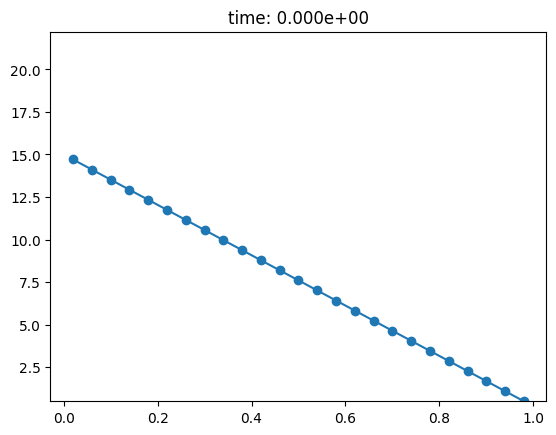

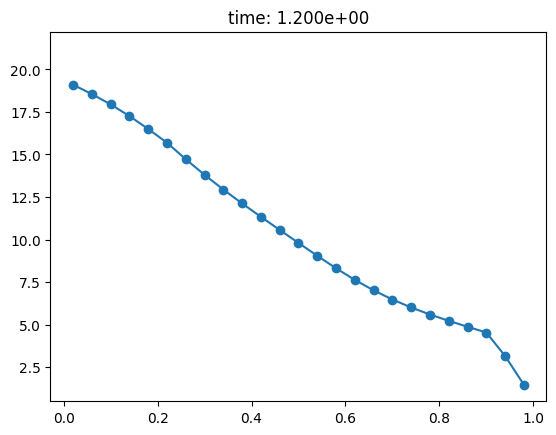

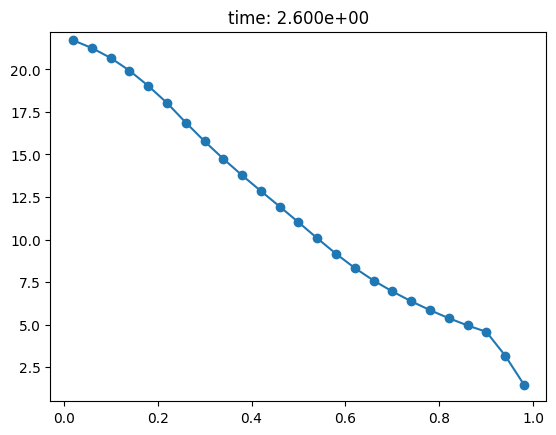

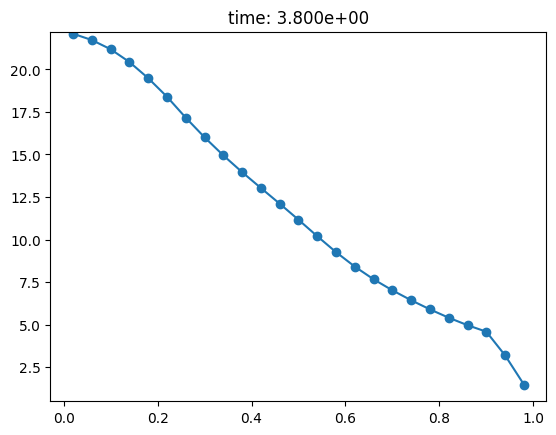

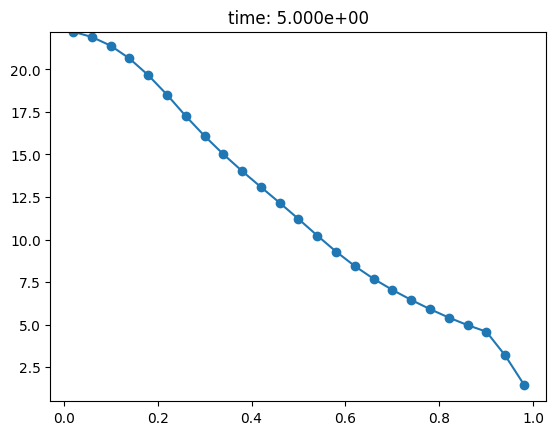

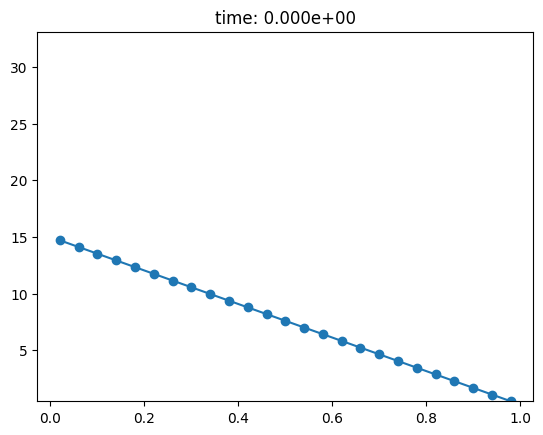

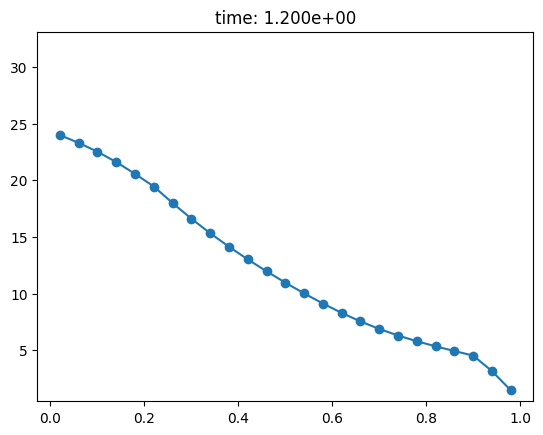

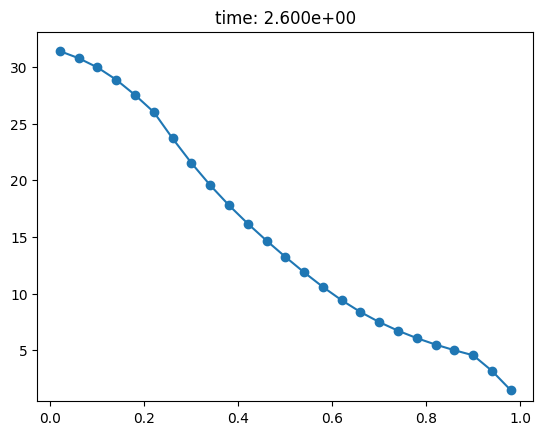

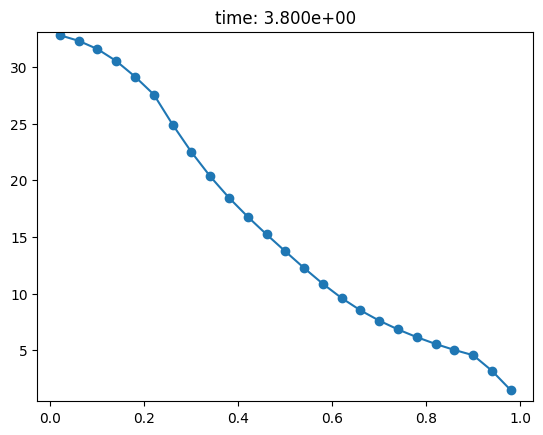

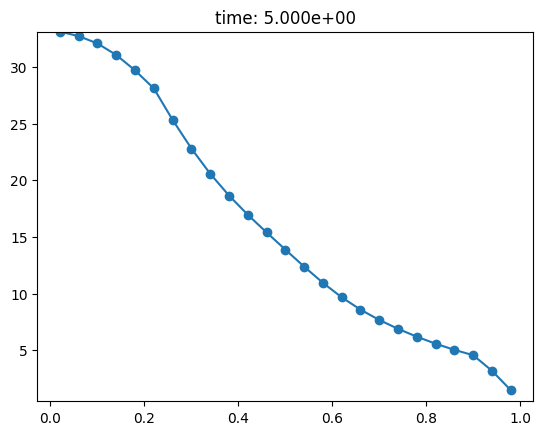

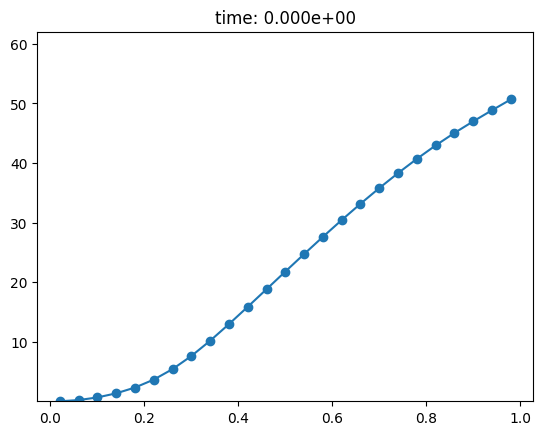

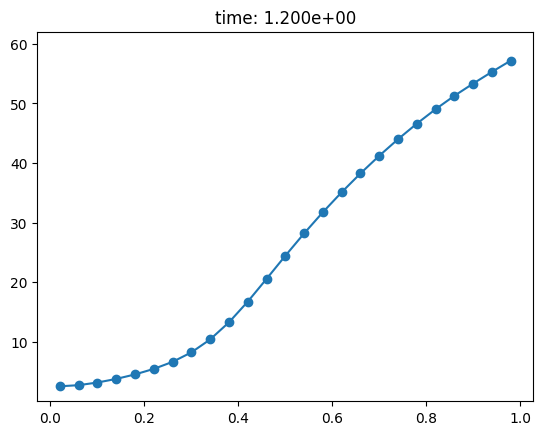

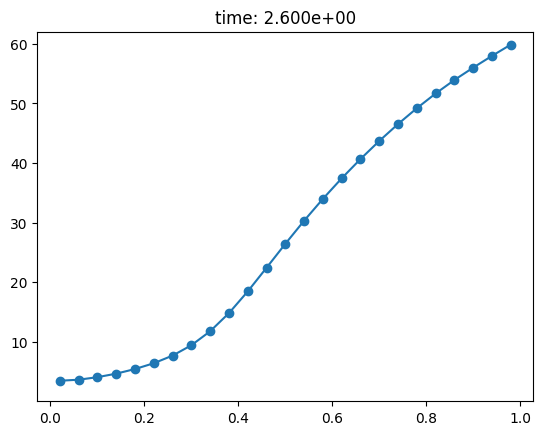

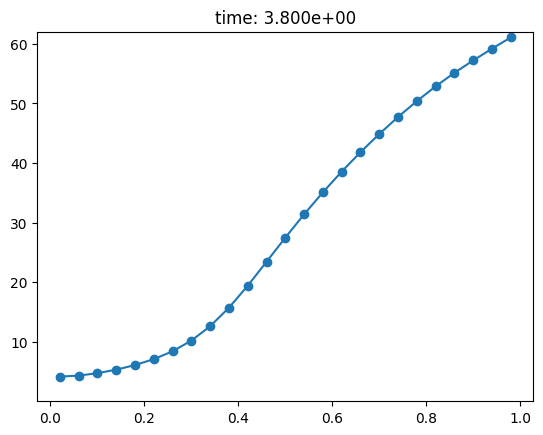

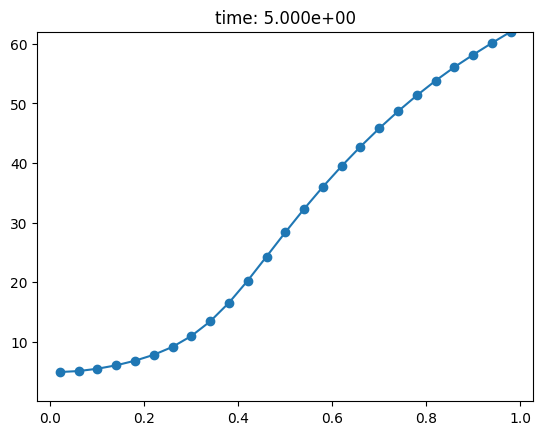

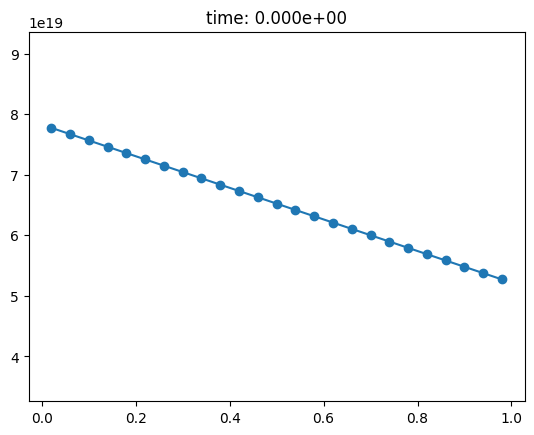

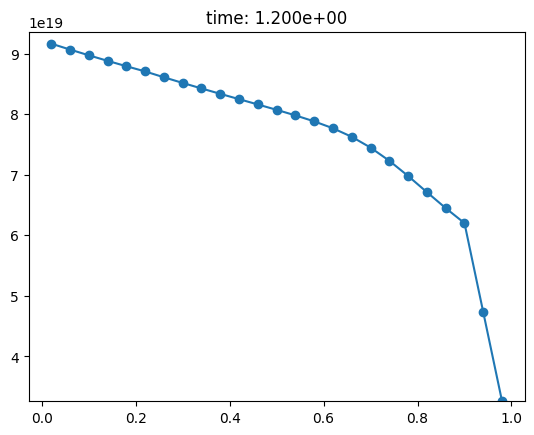

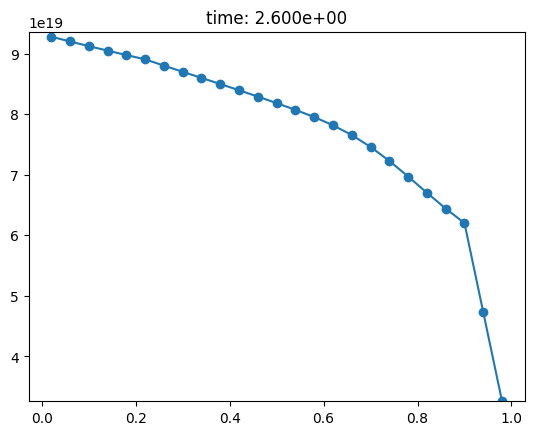

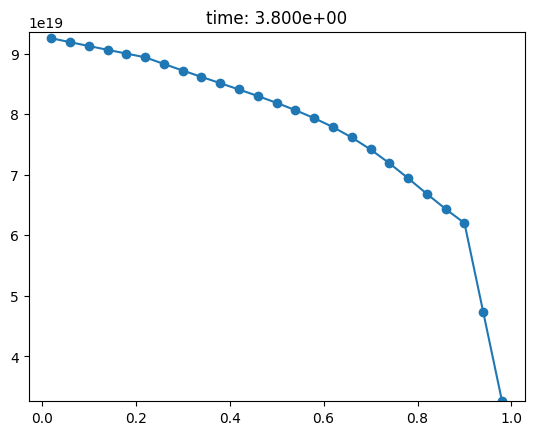

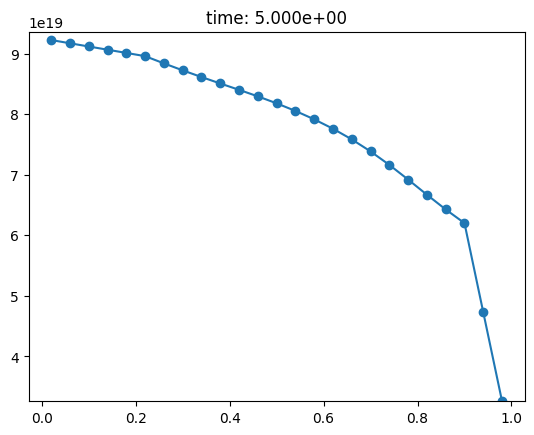

In [ ]:
import matplotlib.pyplot as plt
import mmap

n = 25
dx = 1 / n
cell_centers = (np.arange(n) + 0.5) * dx
rc = 1 + 4 * n
sz = np.dtype(np.float64).itemsize
with open("run.raw", "rb") as f:
    mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
    nt = len(mm) // (rc * sz)
    t_out = np.ndarray(shape=(nt, ),
                       dtype=np.float64,
                       buffer=mm,
                       offset=0,
                       strides=(rc * sz, ))
    states = np.ndarray(shape=(nt, 4, n),
                        dtype=np.float64,
                        buffer=mm,
                        offset=sz,
                        strides=(rc * sz, n * sz, sz))
    for j, var_name in enumerate(("T_i", "T_e", "psi", "n_e")):
        var = states[:, j]
        lo, hi = np.min(var), np.max(var)
        plt.figure()
        plt.title(var_name)
        plt.axis([None, None, lo, hi])
        for idx in [0, nt // 4, nt // 2, 3 * nt // 4, nt - 1]:
            plt.plot(cell_centers, var[idx], "o-", label=f"t={t_out[idx]:.3e}s")
        plt.legend()
        plt.xlabel("rho_norm")
        plt.ylabel(var_name)
        plt.savefig(f"{var_name}.png")
        plt.show()
